In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Torch version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Torch version: 2.9.1+cu128
Device: cpu


In [10]:
class Expert(nn.Module):
    """Standard expert (FFN)"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        hidden = F.gelu(self.w1(x))
        hidden = self.dropout(hidden)
        output = self.w2(hidden)
        return self.dropout(output)

print("✓ Expert module ready")

✓ Expert module ready


In [11]:
class SoftMoELayer(nn.Module):
    """
    Soft MoE: A radical rethinking of MoE routing!
    
    Key Innovation:
    Instead of discrete routing (token → expert), 
    Soft MoE uses continuous mixing through "slots"
    
    Traditional MoE:
    Token A → Expert 1 (discrete)
    Token B → Expert 3 (discrete)
    
    Soft MoE:
    Slot 1 = 0.3*TokenA + 0.5*TokenB + 0.2*TokenC
    Slot 2 = 0.1*TokenA + 0.7*TokenC + 0.2*TokenD
    
    Each slot is processed by an expert, then mixed back
    
    Advantages:
    ✓ Fully differentiable (no discrete decisions)
    ✓ Every expert processes every batch
    ✓ No load balancing issues
    ✓ More parameter efficient
    
    Paper: "From Sparse to Soft Mixtures of Experts" (Puigcerver et al., 2023)
    """
    def __init__(
        self,
        d_model=512,
        d_ff=2048,
        num_experts=8,
        num_slots=128,  # Number of "virtual tokens" 
        dropout=0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        self.num_experts = num_experts
        self.num_slots = num_slots
        
        # Slot attention: how to combine tokens into slots
        self.phi = nn.Linear(d_model, num_slots, bias=False)  # Token → Slot weights
        
        # Expert weights: how slots are processed by experts
        self.experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(num_experts)
        ])
        
        # Dispatch: which expert processes which slot
        self.slot_to_expert = nn.Parameter(torch.randn(num_slots, num_experts))
        
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
            
        Returns:
            output: [batch, seq_len, d_model]
        """
        batch_size, seq_len, d_model = x.shape
        num_tokens = batch_size * seq_len
        
        # Flatten tokens
        x_flat = x.view(num_tokens, d_model)  # [N, d_model]
        
        # Step 1: Compute dispatch weights (tokens → slots)
        # "How much of each token goes into each slot?"
        dispatch_logits = self.phi(x_flat)  # [N, num_slots]
        dispatch_weights = F.softmax(dispatch_logits, dim=0)  # Normalize over tokens
        
        # Step 2: Create slots by mixing tokens
        # Each slot is a weighted combination of all tokens
        slots = torch.matmul(dispatch_weights.T, x_flat)  # [num_slots, d_model]
        
        # Step 3: Compute expert weights for each slot
        # "Which expert processes which slot?"
        expert_weights = F.softmax(self.slot_to_expert, dim=-1)  # [num_slots, num_experts]
        
        # Step 4: Process slots through experts
        expert_outputs = []
        for i, expert in enumerate(self.experts):
            # Get slots weighted for this expert
            expert_input = slots  # [num_slots, d_model]
            expert_output = expert(expert_input)  # [num_slots, d_model]
            expert_outputs.append(expert_output)
        
        expert_outputs = torch.stack(expert_outputs, dim=0)  # [num_experts, num_slots, d_model]
        
        # Step 5: Combine expert outputs per slot
        # Each slot's output is a weighted combination of expert outputs
        combined_slots = torch.einsum('se,esd->sd', expert_weights, expert_outputs)
        # [num_slots, d_model]
        
        # Step 6: Combine back to tokens (slots → tokens)
        # "How to distribute slot outputs back to original tokens?"
        combine_weights = F.softmax(dispatch_logits, dim=1)  # [N, num_slots]
        output_flat = torch.matmul(combine_weights, combined_slots)  # [N, d_model]
        
        # Reshape
        output = output_flat.view(batch_size, seq_len, d_model)
        
        return output, dispatch_weights, expert_weights

# Test Soft MoE
soft_moe = SoftMoELayer(
    d_model=512,
    d_ff=2048,
    num_experts=8,
    num_slots=32,  # Fewer slots than tokens for compression
    dropout=0.1
)

x = torch.randn(2, 20, 512)  # 40 tokens → 32 slots
output, dispatch_weights, expert_weights = soft_moe(x)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"Dispatch weights: {dispatch_weights.shape} (tokens → slots)")
print(f"Expert weights: {expert_weights.shape} (slots → experts)")
print(f"\n✓ Soft MoE working!")
print(f"✓ Fully differentiable routing!")

Input:  torch.Size([2, 20, 512])
Output: torch.Size([2, 20, 512])
Dispatch weights: torch.Size([40, 32]) (tokens → slots)
Expert weights: torch.Size([32, 8]) (slots → experts)

✓ Soft MoE working!
✓ Fully differentiable routing!


In [12]:
class MultiHeadAttention(nn.Module):
    """Standard multi-head attention"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape
        
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        out = self.w_o(out)
        
        return out


class SoftMoETransformerLayer(nn.Module):
    """
    Complete Soft MoE Transformer Layer
    Attention + Soft MoE
    """
    def __init__(
        self,
        d_model=512,
        num_heads=8,
        d_ff=2048,
        num_experts=8,
        num_slots=128,
        dropout=0.1
    ):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.soft_moe = SoftMoELayer(d_model, d_ff, num_experts, num_slots, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention
        residual = x
        x = self.norm1(x)
        attn_out = self.self_attn(x, mask)
        x = residual + self.dropout(attn_out)
        
        # Soft MoE
        residual = x
        x = self.norm2(x)
        moe_out, dispatch_weights, expert_weights = self.soft_moe(x)
        x = residual + self.dropout(moe_out)
        
        return x, dispatch_weights, expert_weights

# Test complete layer
soft_transformer = SoftMoETransformerLayer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_experts=8,
    num_slots=32,
    dropout=0.1
)

x = torch.randn(2, 20, 512)
output, dispatch_weights, expert_weights = soft_transformer(x)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"✓ Soft MoE Transformer working!")

Input:  torch.Size([2, 20, 512])
Output: torch.Size([2, 20, 512])
✓ Soft MoE Transformer working!


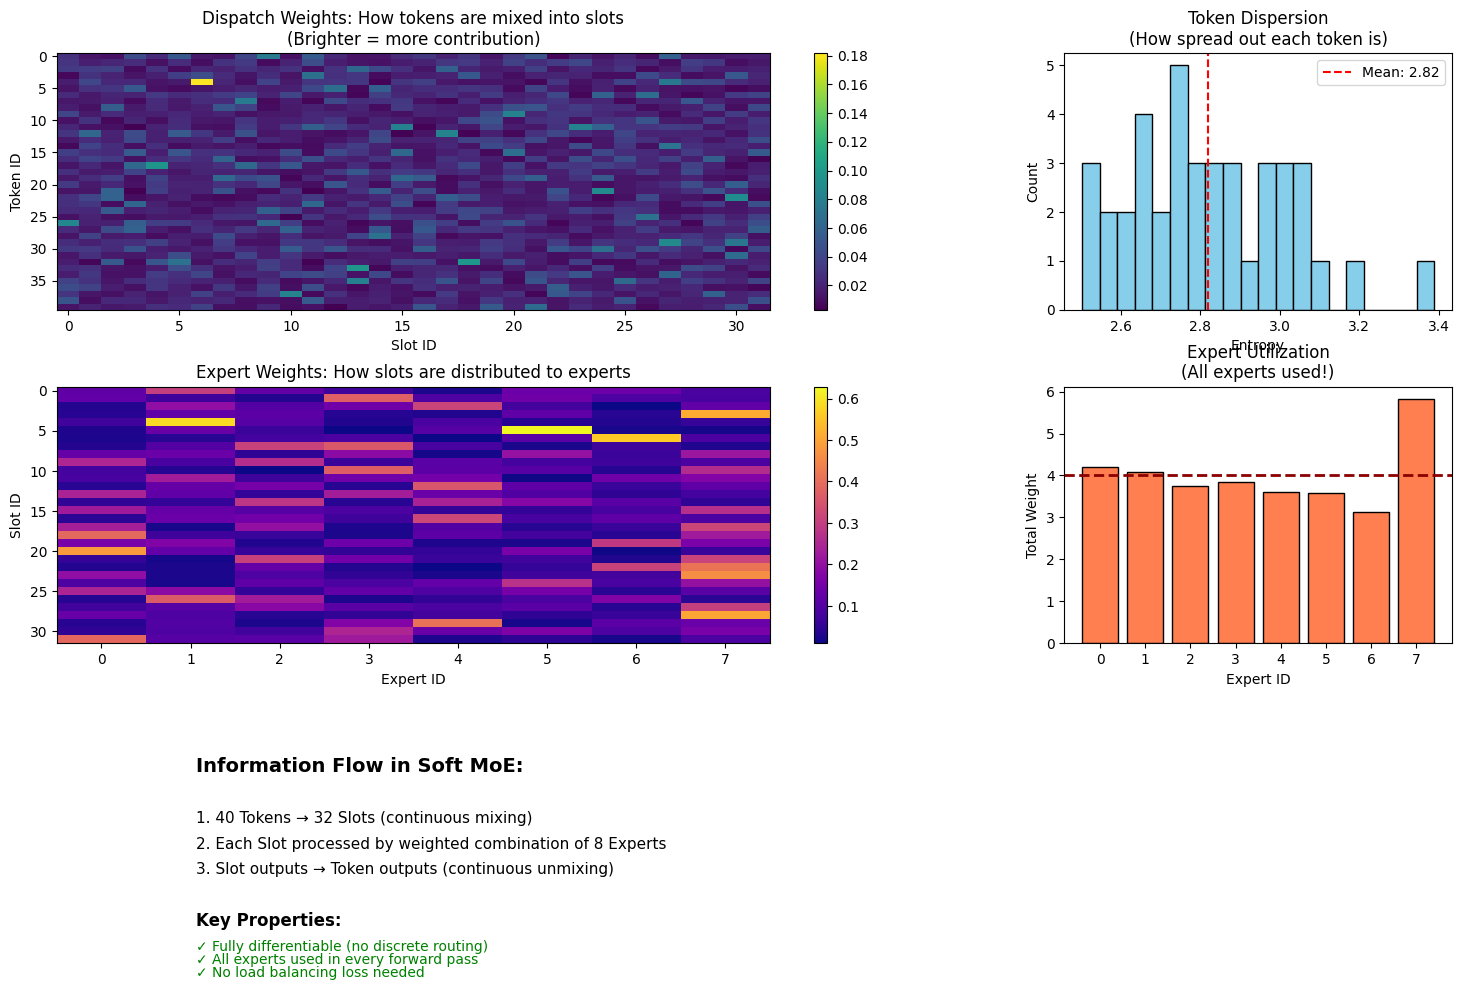


📊 Soft MoE Statistics:
Tokens: 40
Slots: 32
Experts: 8

Token Dispersion (entropy):
  Mean: 2.8199
  Std:  0.1957
  (Higher = more spread across slots)

Expert Utilization:
  Expert 0: 4.1927
  Expert 1: 4.0946
  Expert 2: 3.7447
  Expert 3: 3.8371
  Expert 4: 3.5954
  Expert 5: 3.5856
  Expert 6: 3.1246
  Expert 7: 5.8254

✓ All experts actively participate!
✓ No routing collapse!


In [13]:
def visualize_soft_moe(model, x):
    """
    Visualize the continuous mixing in Soft MoE
    """
    soft_moe_layer = model.soft_moe if hasattr(model, 'soft_moe') else model
    
    with torch.no_grad():
        _, dispatch_weights, expert_weights = soft_moe_layer(x)
    
    batch_size, seq_len, _ = x.shape
    num_tokens = batch_size * seq_len
    
    # Convert to numpy
    dispatch_np = dispatch_weights.cpu().numpy()  # [num_tokens, num_slots]
    expert_np = expert_weights.cpu().numpy()      # [num_slots, num_experts]
    
    # Create visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Token → Slot dispatch weights
    ax1 = fig.add_subplot(gs[0, :2])
    im1 = ax1.imshow(dispatch_np, cmap='viridis', aspect='auto')
    ax1.set_xlabel('Slot ID')
    ax1.set_ylabel('Token ID')
    ax1.set_title('Dispatch Weights: How tokens are mixed into slots\n(Brighter = more contribution)')
    plt.colorbar(im1, ax=ax1)
    
    # Plot 2: Slot → Expert weights
    ax2 = fig.add_subplot(gs[1, :2])
    im2 = ax2.imshow(expert_np, cmap='plasma', aspect='auto')
    ax2.set_xlabel('Expert ID')
    ax2.set_ylabel('Slot ID')
    ax2.set_title('Expert Weights: How slots are distributed to experts')
    plt.colorbar(im2, ax=ax2)
    
    # Plot 3: Token contribution distribution (per token)
    ax3 = fig.add_subplot(gs[0, 2])
    token_entropy = -(dispatch_np * np.log(dispatch_np + 1e-10)).sum(axis=1)
    ax3.hist(token_entropy, bins=20, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Entropy')
    ax3.set_ylabel('Count')
    ax3.set_title('Token Dispersion\n(How spread out each token is)')
    ax3.axvline(token_entropy.mean(), color='red', linestyle='--', 
                label=f'Mean: {token_entropy.mean():.2f}')
    ax3.legend()
    
    # Plot 4: Expert utilization
    ax4 = fig.add_subplot(gs[1, 2])
    expert_usage = expert_np.sum(axis=0)
    bars = ax4.bar(range(len(expert_usage)), expert_usage, color='coral', edgecolor='black')
    ax4.set_xlabel('Expert ID')
    ax4.set_ylabel('Total Weight')
    ax4.set_title('Expert Utilization\n(All experts used!)')
    ax4.axhline(y=expert_usage.mean(), color='darkred', linestyle='--', linewidth=2)
    
    # Plot 5: Information flow diagram
    ax5 = fig.add_subplot(gs[2, :])
    ax5.text(0.1, 0.8, "Information Flow in Soft MoE:", 
             fontsize=14, weight='bold', transform=ax5.transAxes)
    ax5.text(0.1, 0.6, 
             f"1. {num_tokens} Tokens → {soft_moe_layer.num_slots} Slots (continuous mixing)",
             fontsize=11, transform=ax5.transAxes)
    ax5.text(0.1, 0.5, 
             f"2. Each Slot processed by weighted combination of {soft_moe_layer.num_experts} Experts",
             fontsize=11, transform=ax5.transAxes)
    ax5.text(0.1, 0.4, 
             f"3. Slot outputs → Token outputs (continuous unmixing)",
             fontsize=11, transform=ax5.transAxes)
    
    ax5.text(0.1, 0.2, "Key Properties:", fontsize=12, weight='bold', transform=ax5.transAxes)
    ax5.text(0.1, 0.1, "✓ Fully differentiable (no discrete routing)", 
             fontsize=10, color='green', transform=ax5.transAxes)
    ax5.text(0.1, 0.05, "✓ All experts used in every forward pass", 
             fontsize=10, color='green', transform=ax5.transAxes)
    ax5.text(0.1, 0.0, "✓ No load balancing loss needed", 
             fontsize=10, color='green', transform=ax5.transAxes)
    
    ax5.axis('off')
    
    plt.show()
    
    # Print statistics
    print(f"\n📊 Soft MoE Statistics:")
    print(f"{'='*60}")
    print(f"Tokens: {num_tokens}")
    print(f"Slots: {soft_moe_layer.num_slots}")
    print(f"Experts: {soft_moe_layer.num_experts}")
    print(f"\nToken Dispersion (entropy):")
    print(f"  Mean: {token_entropy.mean():.4f}")
    print(f"  Std:  {token_entropy.std():.4f}")
    print(f"  (Higher = more spread across slots)")
    
    print(f"\nExpert Utilization:")
    for i, usage in enumerate(expert_usage):
        print(f"  Expert {i}: {usage:.4f}")
    print(f"\n✓ All experts actively participate!")
    print(f"✓ No routing collapse!")

# Test visualization
soft_moe = SoftMoELayer(d_model=512, num_experts=8, num_slots=32)
x = torch.randn(2, 20, 512)
visualize_soft_moe(soft_moe, x)

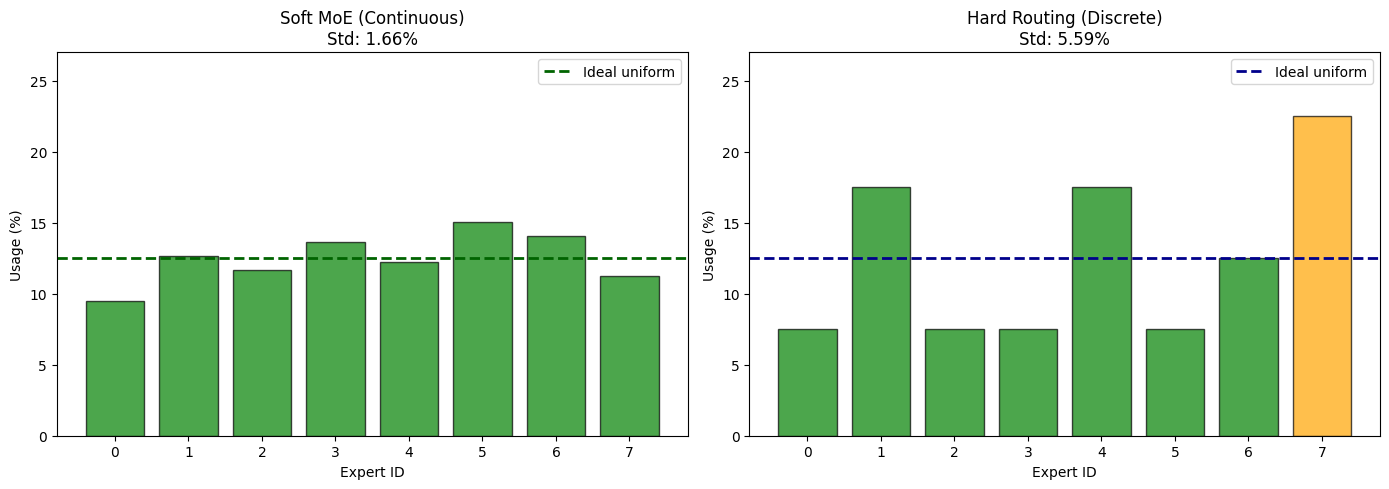


📊 Routing Comparison:
Method               Std Dev         Min Usage       Max Usage      
----------------------------------------------------------------------
Soft MoE             1.66            9.45            15.05          
Hard Routing         5.59            7.50            22.50          

Key Differences:
  Soft MoE:
    ✓ Every expert used in every batch
    ✓ Smooth, differentiable routing
    ✓ Better parameter utilization

  Hard Routing:
    • Discrete expert selection
    • Some experts may be idle
    • Requires load balancing losses


In [14]:
def compare_soft_vs_hard_routing():
    """
    Compare Soft MoE's continuous routing with traditional discrete routing
    """
    d_model = 512
    num_experts = 8
    x = torch.randn(2, 20, d_model)
    
    # Soft MoE
    soft_moe = SoftMoELayer(d_model, 2048, num_experts, num_slots=32)
    _, dispatch_weights, expert_weights = soft_moe(x)
    
    # Compute effective expert usage in Soft MoE
    soft_usage = expert_weights.sum(dim=0).detach().cpu().numpy()
    soft_usage = soft_usage / soft_usage.sum() * 100
    
    # Hard routing (Switch-style)
    class HardRouter(nn.Module):
        def __init__(self, d_model, num_experts):
            super().__init__()
            self.gate = nn.Linear(d_model, num_experts, bias=False)
        
        def forward(self, x):
            logits = self.gate(x.view(-1, d_model))
            indices = torch.argmax(logits, dim=-1)
            return indices
    
    hard_router = HardRouter(d_model, num_experts)
    with torch.no_grad():
        hard_indices = hard_router(x)
        hard_counts = torch.bincount(hard_indices, minlength=num_experts).cpu().numpy()
        hard_usage = hard_counts / hard_counts.sum() * 100
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Soft MoE
    ax = axes[0]
    bars = ax.bar(range(num_experts), soft_usage, color='green', alpha=0.7, edgecolor='black')
    ax.axhline(y=100/num_experts, color='darkgreen', linestyle='--', linewidth=2, 
               label='Ideal uniform')
    ax.set_xlabel('Expert ID')
    ax.set_ylabel('Usage (%)')
    ax.set_title(f'Soft MoE (Continuous)\nStd: {soft_usage.std():.2f}%')
    ax.legend()
    ax.set_ylim(0, max(soft_usage.max(), hard_usage.max()) * 1.2)
    
    # Hard routing
    ax = axes[1]
    colors = ['green' if 5 < u < 20 else 'orange' if u > 0 else 'red' for u in hard_usage]
    bars = ax.bar(range(num_experts), hard_usage, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=100/num_experts, color='darkblue', linestyle='--', linewidth=2,
               label='Ideal uniform')
    ax.set_xlabel('Expert ID')
    ax.set_ylabel('Usage (%)')
    ax.set_title(f'Hard Routing (Discrete)\nStd: {hard_usage.std():.2f}%')
    ax.legend()
    ax.set_ylim(0, max(soft_usage.max(), hard_usage.max()) * 1.2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Routing Comparison:")
    print(f"{'='*70}")
    print(f"{'Method':<20} {'Std Dev':<15} {'Min Usage':<15} {'Max Usage':<15}")
    print(f"{'-'*70}")
    print(f"{'Soft MoE':<20} {soft_usage.std():<15.2f} {soft_usage.min():<15.2f} {soft_usage.max():<15.2f}")
    print(f"{'Hard Routing':<20} {hard_usage.std():<15.2f} {hard_usage.min():<15.2f} {hard_usage.max():<15.2f}")
    
    print(f"\nKey Differences:")
    print(f"  Soft MoE:")
    print(f"    ✓ Every expert used in every batch")
    print(f"    ✓ Smooth, differentiable routing")
    print(f"    ✓ Better parameter utilization")
    
    print(f"\n  Hard Routing:")
    print(f"    • Discrete expert selection")
    print(f"    • Some experts may be idle")
    print(f"    • Requires load balancing losses")

compare_soft_vs_hard_routing()